# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import sklearn.datasets as  datasets
import matplotlib.pyplot as plt

import pydot as pyd # Install using pip install pydot 


from   sklearn                  import  tree
from   sklearn.tree             import  DecisionTreeClassifier
from sklearn.preprocessing      import LabelEncoder

from   sklearn                  import  metrics 
from   sklearn.metrics          import  classification_report
from   sklearn.metrics          import  confusion_matrix
from   sklearn.metrics          import  accuracy_score
from   sklearn.metrics          import  roc_curve, auc
from   sklearn.model_selection  import  KFold 
from   sklearn.model_selection  import  train_test_split
import pydotplus #install using pip install pydotplus

# Commet this if the data visualisations doesn't work on your side
%matplotlib inline 

In [2]:
from   sklearn.model_selection import  cross_val_score

# WRITE FUNCTIONS CONFUSION MATRIX

In [3]:
def draw_cm( actual, predicted ):
    
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    cm = metrics.confusion_matrix( actual, predicted, [1,0] )
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# FUNCTIONS FOR ROC CURVE

In [4]:
def draw_roc( actual, probs ):

    import pandas            as   pd
    import numpy             as   np
    import seaborn           as   sns
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
    drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [5]:
def decision_tree_with_pruning(clf, X, y, flist, file_name):
    from sklearn.tree            import export_graphviz
    from sklearn.externals.six   import StringIO  
    from IPython.core.pylabtools import figsize
    from IPython.display         import Image
    figsize(12.5, 6)
    import pydot
    #dot_data = StringIO()  
    file_name_dot = file_name + '.dot'
    file_name_png = file_name + '.png'
    
    export_graphviz(clf, out_file = file_name_dot, feature_names = flist,
                    class_names = ['No Thyroid' , 'Thyroid'],
                    filled = True, rounded = True)
    (graph,) = pydot.graph_from_dot_file(file_name_dot)
    graph.write_png(file_name_png)
    return Image(file_name_png)

### Decision rules from CART

In [6]:
'''
This function returns a set of rules defined in the Decision Tree which is easy to understand
'''
def tree_to_rules(tree, feature_names, class_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):

        indent = "  " * depth

        if (threshold[node] != -2):

            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")

            if left[node] != -1:

                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")

                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)

                print(indent,"}")

        else:
            if value[node][0,0] > value[node][0,1]:
              classified = class_names[0]
            else:
              classified = class_names[1]
            print(indent,"Class = " + classified)
    recurse(left, right, threshold, features, 0)

### Optimum cut-off

We know the data set is not balanced and hence the standard cut-off of 50% for creating the confusion matrix will not hold good. We need to find the optimum cut-off to divide the data set into two classes.

In [7]:
"""
  This function calculates the Youdens J score which gives the optimum cut-off point given                 the fpr, tpr and thresholds
"""
def get_youdens_j_cutoff(fpr,tpr,thresholds):
    j_scores = np.abs(tpr - fpr)
    j_ordered = sorted(zip(j_scores,thresholds, fpr, tpr))
    # Plot tpr vs 1-fpr
    fig, ax = plt.subplots()
    plt.plot(tpr)
    plt.plot(1-fpr, color = 'red')
    plt.xlabel('1-False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ax.set_xticklabels([])
    res = {'fpr': j_ordered[-1][2], 'tpr': j_ordered[-1][3], 'threshold' : j_ordered[-1][1]}
    return res

In [8]:
'''
This function calculates the Youdens J score which gives the optimum cut-off
point given the fpr, tpr and thresholds
'''
def get_youdens_j_cutoff(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

In [12]:
import os; os.chdir("C:/Users/gayat/Desktop/Capstone")


In [13]:
import os; os.getcwd()

'C:\\Users\\gayat\\Desktop\\Capstone'

In [14]:
#df = pd.read_csv('D:/GREAT LAKES/CAPSTONE/hypothyroid.csv')
df = pd.read_csv('./hypothyroid.csv')

In [15]:
df.binaryClass.value_counts()

P    3481
N     291
Name: binaryClass, dtype: int64

# Identifying the shape and structure of the Data frame

In [16]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
age                          3772 non-null object
sex                          3772 non-null object
on thyroxine                 3772 non-null object
query on thyroxine           3772 non-null object
on antithyroid medication    3772 non-null object
sick                         3772 non-null object
pregnant                     3772 non-null object
thyroid surgery              3772 non-null object
I131 treatment               3772 non-null object
query hypothyroid            3772 non-null object
query hyperthyroid           3772 non-null object
lithium                      3772 non-null object
goitre                       3772 non-null object
tumor                        3772 non-null object
hypopituitary                3772 non-null object
psych                        3772 non-null object
TSH measured                 3772 non-null object
TSH                          3772 non-null 

(3772, 30)

### Overall summary Report of the Thyroid Dataset

In [17]:
df['binaryClass'].value_counts()

P    3481
N     291
Name: binaryClass, dtype: int64

All the Numerical values have high cardinality and provides an overview of the dataset 

In [18]:
df['binaryClass_N'] = df['binaryClass'].apply(lambda x: 1 if x == 'P' else 0)

In [19]:
df['binaryClass_N'].value_counts()

1    3481
0     291
Name: binaryClass_N, dtype: int64

### Check if the data is balanced or not

In [20]:
df['binaryClass_N'].value_counts().apply(lambda x: [x, ( x * 100) / df.shape[0]])

1    [3481, 92.28525980911984]
0     [291, 7.714740190880169]
Name: binaryClass_N, dtype: object

# Data Processing steps

1. Target Variable is converted to Categorical Variable by assigning specific values . Here , the prediction is considered to be positive. So P is assigned as '1'
2. There are no Values present in TBG and TBG Measured value was 'false' . Hence the values are removed from the dataset
3. Overall summary after the removal of columns is provided 

In [21]:
df.drop(columns = ['TBG measured','binaryClass'], axis = 0, inplace = True)

In [22]:
df.shape

(3772, 29)

In [23]:
feature_names   = df.columns
class_names   =  ['No Thyroid','Thyroid']
print(feature_names)

Index(['age', 'sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH',
       'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U',
       'FTI measured', 'FTI', 'TBG', 'referral source', 'binaryClass_N'],
      dtype='object')


# All the columns were imported as objects . Hence they were converted into categorical variables and floating point functions

In [24]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64'])
df_num.head()

""
0
1
2
3
4


In [25]:
for col in df.columns:
    if df[col].dtype==object and col not in ["age", "TSH","T3","TT4","T4U","FTI","binaryClass_N"]:
        print(col)
        lbl = LabelEncoder()
        lbl.fit(list(df[col].values.astype('str'))) 
        df[col] = lbl.transform(list(df[col].values.astype('str')))

sex
on thyroxine
query on thyroxine
on antithyroid medication
sick
pregnant
thyroid surgery
I131 treatment
query hypothyroid
query hyperthyroid
lithium
goitre
tumor
hypopituitary
psych
TSH measured
T3 measured
TT4 measured
T4U measured
FTI measured
TBG
referral source


#### Before the EDA Process , there are numerous null values in the Data set. Actions are taken to manipulate the null values before proceeding

In [26]:
df1 = df.replace('?', np.NaN)
print(df1.isnull().sum())
df1.shape

age                            1
sex                            0
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                          369
T3 measured                    0
T3                           769
TT4 measured                   0
TT4                          231
T4U measured                   0
T4U                          387
FTI measured                   0
FTI                          385
TBG                            0
referral source                0
binaryClass_N                  0
dtype: int64


(3772, 29)

# Dropping Missing Values 

In [27]:
df1.dropna(inplace=True)

In [28]:
df1.shape

(2751, 29)

In [29]:
df1['age'] = df1['age'].astype('int32')
df1['TSH'] = df1['TSH'].astype('float64')
df1['T3']  = df1['T3'].astype('float64')
df1['TT4'] = df1['TT4'].astype('float64')
df1['T4U'] = df1['T4U'].astype('float64')
df1['FTI'] = df1['FTI'].astype('float64')

In [30]:
list(set(df1.dtypes.tolist()))
df1_num = df1.select_dtypes(include = ['float64','int32'])

# EDA

Plot of various graphs to understand the importance of the numeric variables that may affect the Thyroid prediction

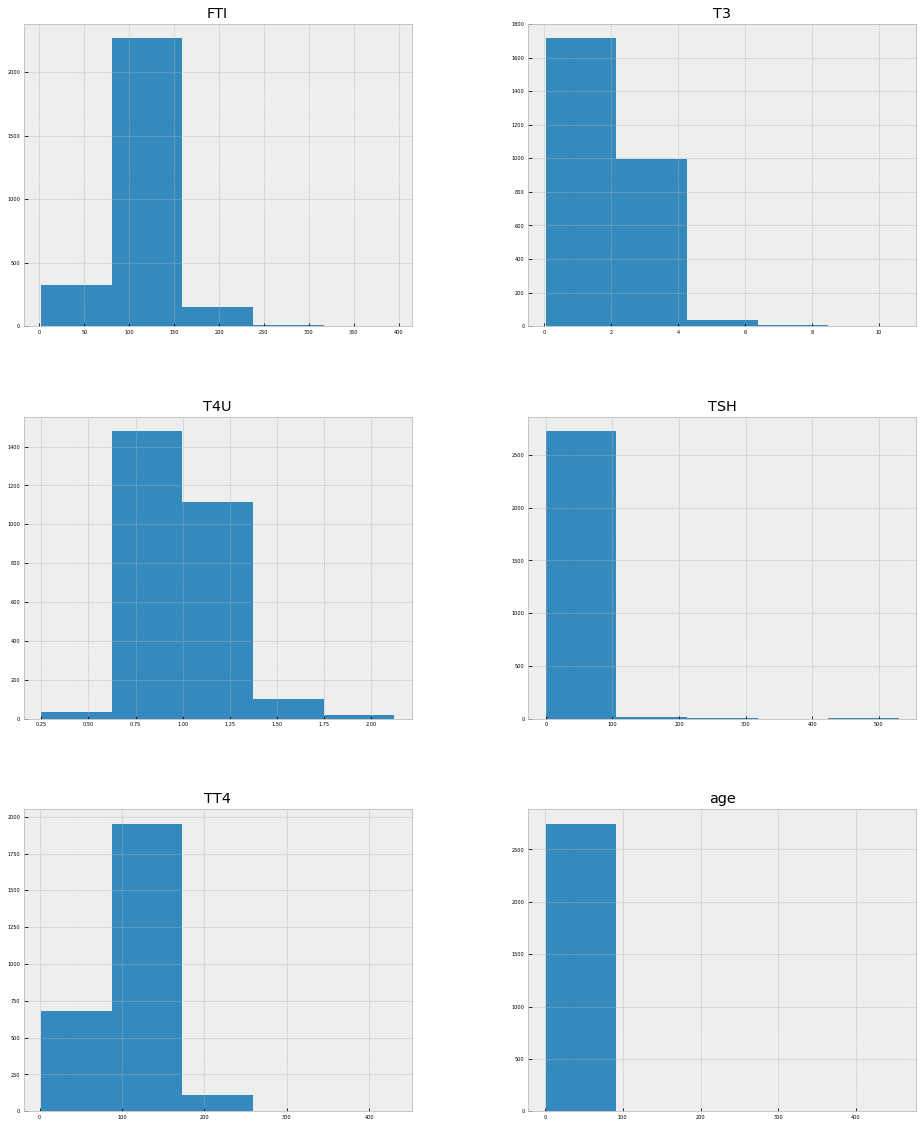

In [31]:
plt.style.use('bmh')
df1_num.hist(figsize=(16, 20), bins=5, xlabelsize=5, ylabelsize=5);
plt.savefig('thyroid.jpg')

# Correlation

Correlation of the variables with Target Variable :
Correlation is Calculated among the numeric variables . None of the Variables had a correlation function of greater than 0.5 and
also from the correlation co-efficients it can be concluded that more than the categorical variables the numerical variables like the TT4,
T4u and T3 harmones has higher impact in predicting the thyroid among patients 

In [32]:
df1_num = df1.select_dtypes(include = ['float64','int64','int32'])
df1_num_corr = df1_num.corr()['binaryClass_N'][:-1] 
golden_features_list = df1_num_corr[abs(df1_num_corr) > 0.1].sort_values(ascending=False)
print("There is {} strongly correlated values with binaryClass:\n{}".format(len(golden_features_list), golden_features_list))



There is 4 strongly correlated values with binaryClass:
FTI    0.354430
TT4    0.317290
T3     0.194511
TSH   -0.440955
Name: binaryClass_N, dtype: float64


Correlation among the Variables :
Same point illustrated above implies here too. Correlation is strong among the numeric variables and they predict the Thyroid in patients

# Correlation plot among independant variables

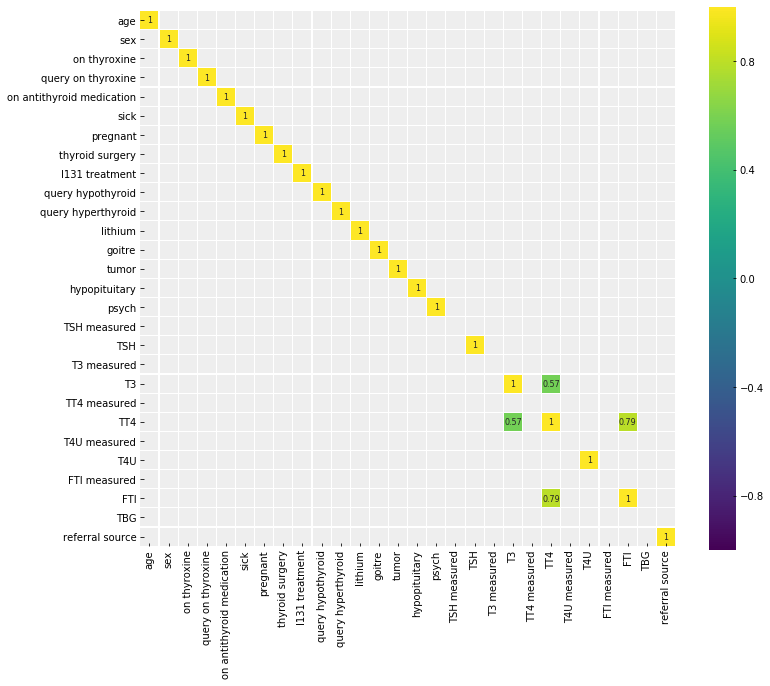

In [34]:
import seaborn as sns
corr = df1_num.drop('binaryClass_N', axis=1).corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);
plt.savefig('Corr.jpg')

# TO GET THE PROPORTION OF CATEGORY IN EACH COLUMNS

In [35]:
categorical_columns = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', \
                        'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', \
                        'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured',\
                        'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured', \
                        'referral source', 'binaryClass_N']
for name1 in categorical_columns:
    print("\nColumn: ", name1,"\n")
    print(df1[name1].value_counts())


Column:  sex 

1    1764
2     879
0     108
Name: sex, dtype: int64

Column:  on thyroxine 

0    2471
1     280
Name: on thyroxine, dtype: int64

Column:  query on thyroxine 

0    2727
1      24
Name: query on thyroxine, dtype: int64

Column:  on antithyroid medication 

0    2718
1      33
Name: on antithyroid medication, dtype: int64

Column:  sick 

0    2635
1     116
Name: sick, dtype: int64

Column:  pregnant 

0    2708
1      43
Name: pregnant, dtype: int64

Column:  thyroid surgery 

0    2717
1      34
Name: thyroid surgery, dtype: int64

Column:  I131 treatment 

0    2707
1      44
Name: I131 treatment, dtype: int64

Column:  query hypothyroid 

0    2601
1     150
Name: query hypothyroid, dtype: int64

Column:  query hyperthyroid 

0    2580
1     171
Name: query hyperthyroid, dtype: int64

Column:  lithium 

0    2737
1      14
Name: lithium, dtype: int64

Column:  goitre 

0    2731
1      20
Name: goitre, dtype: int64

Column:  tumor 

0    2691
1      60
Name: tumo

#We cannot use columns with constant values. In our dataset, the following fields have constant value, t for True: a. TSH measured b. T3 measured c. TT4measured d. T4Umeasured e. FTImeasured f. TBGmeasure Also, the field, hypopituitary is having only one value as True, rest as False. So we cannot use this field as well.

So, we remove all these columns


In [36]:
unwanted_columns    = ['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','hypopituitary']
#df1.drop(columns     = unwanted_columns, inplace = True )
categorical_columns = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', \
                        'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', \
                        'lithium', 'goitre', 'tumor', 'psych', 'referral_source', 'binaryClass_N']
feature_names   = df1.columns

In [37]:
print(df1.shape)
feature_names

(2751, 29)


Index(['age', 'sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH',
       'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U',
       'FTI measured', 'FTI', 'TBG', 'referral source', 'binaryClass_N'],
      dtype='object')

In [38]:
df1.binaryClass_N.value_counts()

1    2528
0     223
Name: binaryClass_N, dtype: int64

Observations

We have started with 3772 observations and 30 columns.
* There are ? values for some observations in seven fields and all observations in the field, TBG.
* Those values are removed for the model built 
* Since 100% of observations have null value in the field, TBG, we need to remove the field for our analysis.
* Now, we have 2751 not null observations out of 3772 total observations.
* We have removed TBG column full of null values from the dataframe.
* We have removed columns such as 'TSH measured','T3 measured','TT4 measured','T4U measured','FTI measured','TBG measured' and 'hypopituitary' with constant or near constant values. 
* We have retained only 22 columns instead of 30 columns.

Data is not balanced since the class distribution in the target variable is in the ratio 216: 2427


In [39]:
import seaborn as sns

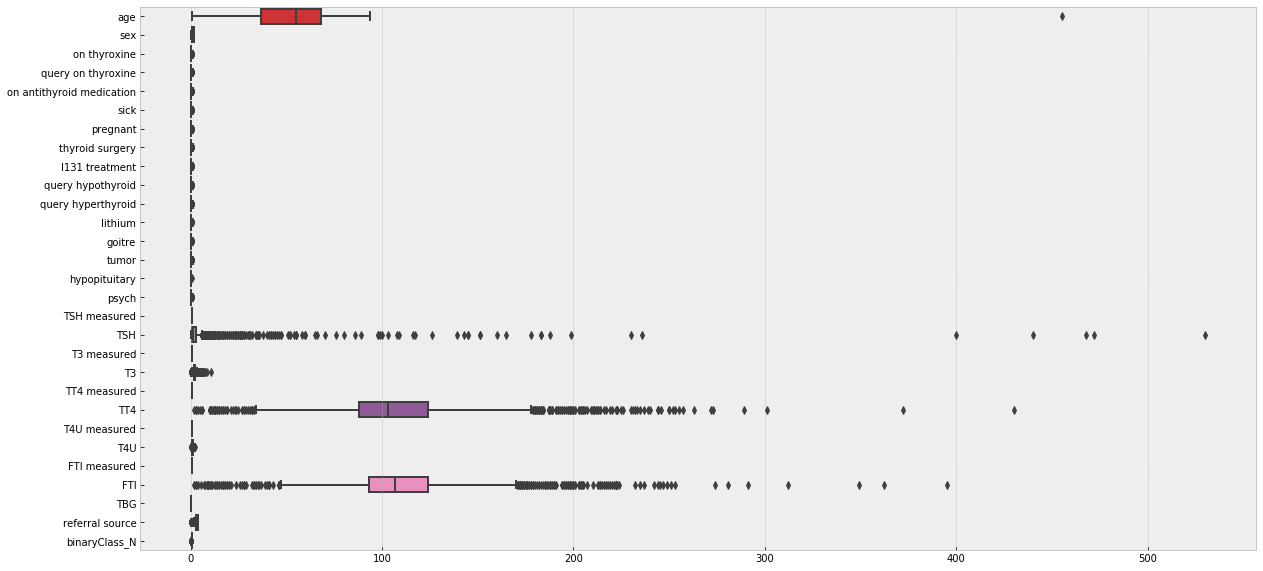

<Figure size 432x288 with 0 Axes>

In [40]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data = df1, orient = "h", palette = "Set1")
plt.show()
plt.savefig('box.jpg')

# Outlier detection function

In [41]:
def outlier_detect(df):
    for i in df.describe().columns:

        Q1=df.describe().at['25%',i]
        Q3=df.describe().at['75%',i]
        IQR=Q3 - Q1
        LTV=Q1 - 1.5 * IQR
        UTV=Q3 + 1.5 * IQR
        x=np.array(df[i])
        p=[]
        for j in x:
            if j < LTV or j>UTV:
               p.append(j)
        print('\n Outliers for Column : ', i, ' Outliers count ', len(p))
        print(p)

In [42]:
all_columns         = list(df1)
numeric_columns     = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
categorical_columns = [x for x in all_columns if x not in numeric_columns ]

print('\nNumeric columns')
print(numeric_columns)
print('\nCategorical columns')
print(categorical_columns)


Numeric columns
['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

Categorical columns
['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured', 'TBG', 'referral source', 'binaryClass_N']


In [43]:
x =  df1[numeric_columns]
outlier_detect(x)


 Outliers for Column :  age  Outliers count  1
[455]

 Outliers for Column :  TSH  Outliers count  291
[6.0, 13.0, 7.3, 45.0, 14.8, 15.0, 19.0, 9.0, 7.8, 160.0, 12.0, 8.8, 151.0, 7.8, 13.0, 6.0, 26.0, 143.0, 108.0, 9.2, 86.0, 9.1, 52.0, 6.1, 31.0, 5.8, 51.0, 6.3, 9.6, 42.0, 12.0, 25.0, 8.6, 6.2, 9.7, 28.0, 17.0, 18.0, 55.0, 14.0, 16.0, 10.0, 6.7, 7.6, 8.0, 11.0, 11.0, 44.0, 7.9, 11.0, 15.0, 7.2, 12.0, 6.4, 7.1, 199.0, 19.0, 24.0, 15.0, 188.0, 98.0, 22.0, 6.6, 7.6, 35.0, 8.2, 12.0, 6.1, 7.1, 11.0, 60.0, 55.0, 22.0, 29.0, 13.0, 7.2, 6.2, 11.0, 6.0, 7.5, 34.0, 10.0, 6.5, 103.0, 9.4, 28.0, 11.0, 7.9, 6.1, 13.0, 8.9, 9.3, 42.0, 7.2, 26.0, 11.0, 6.3, 54.0, 8.3, 7.5, 15.0, 7.1, 15.0, 8.1, 60.0, 18.0, 9.2, 100.0, 17.0, 13.0, 16.0, 41.0, 183.0, 8.9, 10.0, 7.1, 42.0, 12.0, 8.3, 6.9, 12.1, 43.0, 8.2, 18.0, 25.0, 7.3, 8.6, 10.0, 15.0, 8.4, 34.0, 6.8, 8.5, 6.4, 151.0, 11.0, 6.2, 9.0, 11.0, 11.0, 26.0, 6.8, 35.0, 8.1, 38.0, 44.0, 9.9, 6.8, 9.8, 11.0, 6.2, 12.0, 11.1, 27.0, 8.6, 15.0, 7.2, 76.0, 13.

# Create X, independent variable and y dependent variable

In [44]:
feature_names1 =  feature_names.drop('binaryClass_N')
X              =  df1.loc[:,feature_names1] 
y              =  df1.loc[:,'binaryClass_N']
label_names    =  y.unique()
print(X.shape)
print(y.shape)

(2751, 28)
(2751,)


In [45]:
y.value_counts()

1    2528
0     223
Name: binaryClass_N, dtype: int64

In [46]:
y.value_counts().apply(lambda x: [x, ( x * 100) / df.shape[0]])

1    [2528, 67.02014846235419]
0     [223, 5.911983032873807]
Name: binaryClass_N, dtype: object

# Split the data into training and test data set

In [47]:
seed      = 1
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [48]:
clf    = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf    = clf.fit(X_train,y_train)

In [49]:
#Predict the response for test dataset
predicted_test= clf.predict(X_test)
predicted_train=clf.predict(X_train)


Test Data
[[ 62   5]
 [  2 757]]
Training Accuracy: 100.000%
Testing Accuracy: 99.153%


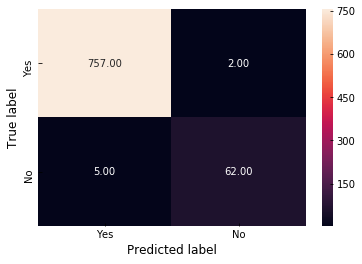

<Figure size 432x288 with 0 Axes>

In [50]:
matrix = confusion_matrix(y_test, predicted_test)
print("\nTest Data")
print(matrix)

accuracy_train = accuracy_score(y_train, predicted_train)
accuracy_test = accuracy_score(y_test, predicted_test)
print("Training Accuracy: %.3f%%" % (accuracy_train * 100.0))
print("Testing Accuracy: %.3f%%" % (accuracy_test * 100.0))
draw_cm(y_test, predicted_test)
plt.savefig('cm.jpg')



# Performance measures calculation

In [51]:
measures_test= classification_report(y_test, predicted_test) 
print("\nTest data")
print(measures_test)


Test data
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        67
           1       0.99      1.00      1.00       759

   micro avg       0.99      0.99      0.99       826
   macro avg       0.98      0.96      0.97       826
weighted avg       0.99      0.99      0.99       826



# ROC Curve for the model 

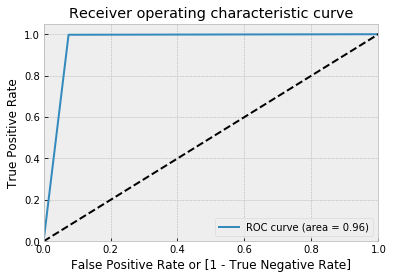

(array([0.        , 0.07462687, 1.        ]),
 array([0.        , 0.99736495, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [52]:
draw_roc(y_test, predicted_test)

In [53]:
df2 = df.replace('?', np.NaN)
print(df2.isnull().sum())
df2.shape

age                            1
sex                            0
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                          369
T3 measured                    0
T3                           769
TT4 measured                   0
TT4                          231
T4U measured                   0
T4U                          387
FTI measured                   0
FTI                          385
TBG                            0
referral source                0
binaryClass_N                  0
dtype: int64


(3772, 29)

# Missing Values using Median

In [54]:
df3=df2.fillna(df2.median())
df3.shape

(3772, 29)

In [55]:
df3.shape

(3772, 29)

In [56]:
df3_num = df3.select_dtypes(include = ['float64','int64','int32'])
df3_num_corr = df3_num.corr()['binaryClass_N'][:-1] 
golden_features_list = df3_num_corr[abs(df3_num_corr) > 0.1].sort_values(ascending=False)
print("There is {} strongly correlated values with Class:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated values with Class:
Series([], Name: binaryClass_N, dtype: float64)


In [57]:
feature_names1 =  feature_names.drop('binaryClass_N')
X              =  df3.loc[:,feature_names1] 
y              =  df3.loc[:,'binaryClass_N']
label_names    =  y.unique()
print(X.shape)
print(y.shape)

(3772, 28)
(3772,)


In [58]:
seed      = 1
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
df2.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG,referral source,binaryClass_N
0,41,1,0,0,0,0,0,0,0,0,...,2.5,1,125,1,1.14,1,109,0,1,1
1,23,1,0,0,0,0,0,0,0,0,...,2,1,102,0,NaN,0,NaN,0,4,1
2,46,2,0,0,0,0,0,0,0,0,...,NaN,1,109,1,0.91,1,120,0,4,1
3,70,1,1,0,0,0,0,0,0,0,...,1.9,1,175,0,NaN,0,NaN,0,4,1
4,70,1,0,0,0,0,0,0,0,0,...,1.2,1,61,1,0.87,1,70,0,3,1


In [59]:
clf1   = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf1    = clf1.fit(X_train,y_train)

In [60]:
#Predict the response for test dataset
predicted_test= clf1.predict(X_test)
predicted_train=clf1.predict(X_train)


Test Data
[[  84    3]
 [   3 1042]]
Training Accuracy: 100.000%
Testing Accuracy: 99.470%


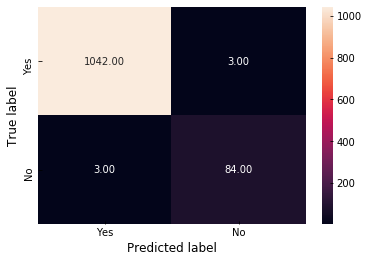

In [61]:
matrix = confusion_matrix(y_test, predicted_test)
print("\nTest Data")
print(matrix)
    
accuracy_train = accuracy_score(y_train, predicted_train)
accuracy_test = accuracy_score(y_test, predicted_test)
print("Training Accuracy: %.3f%%" % (accuracy_train * 100.0))
print("Testing Accuracy: %.3f%%" % (accuracy_test * 100.0))
draw_cm(y_test, predicted_test)

In [62]:
measures_test= classification_report(y_test, predicted_test) 
print("\nTest data")
print(measures_test)


Test data
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        87
           1       1.00      1.00      1.00      1045

   micro avg       0.99      0.99      0.99      1132
   macro avg       0.98      0.98      0.98      1132
weighted avg       0.99      0.99      0.99      1132



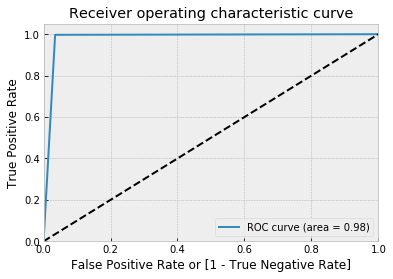

(array([0.        , 0.03448276, 1.        ]),
 array([0.        , 0.99712919, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [63]:
draw_roc(y_test, predicted_test)

### Get the optimum cut-off

In [64]:
threshold_df            =  pd.DataFrame()  
threshold_df['Actual']  = y_train
threshold_df.dropna(inplace = True)

In [65]:
predicted_proba_tr = clf1.predict_proba(X_train)

In [66]:
threshold_df.dropna(inplace = True)

threshold_values = np.arange(0.10, 0.80, 0.02)

cutoff_df        = pd.DataFrame()

for i in range(len(threshold_values)):
    
    threshold                   = threshold_values[i]
    threshold_df['Probability'] = predicted_proba_tr[:,1]
    threshold_df['pred']        = threshold_df['Probability'].map(lambda x: 1 \
                                                                  if x > threshold else 0)
    cm                          = confusion_matrix(threshold_df['Actual'].astype('int'),\
                                                   threshold_df['pred'])
    precision                   = np.diag(cm) / np.sum(cm, axis = 0)
    recall                      = np.diag(cm) / np.sum(cm, axis = 1) 
    accuracy_ratio              = ((cm[0,0] + cm[1,1]) * 100) / (cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    #auroc                       = 
    recall_positive             = recall[1]
    precision_positive          = precision[1]
    cutoff_df_ind               = pd.DataFrame({'Threshold': threshold, 'Recall' : recall_positive,\
                                               'Precision' : precision_positive,\
                                               'Accuracy Ratio' : accuracy_ratio},\
                                              index = [0])
    print(cutoff_df_ind)
    print(cm)
    cutoff_df.append(cutoff_df_ind)  
print(cutoff_df.head())

   Threshold  Recall  Precision  Accuracy Ratio
0        0.1     1.0        1.0           100.0
[[ 204    0]
 [   0 2436]]
   Threshold  Recall  Precision  Accuracy Ratio
0       0.12     1.0        1.0           100.0
[[ 204    0]
 [   0 2436]]
   Threshold  Recall  Precision  Accuracy Ratio
0       0.14     1.0        1.0           100.0
[[ 204    0]
 [   0 2436]]
   Threshold  Recall  Precision  Accuracy Ratio
0       0.16     1.0        1.0           100.0
[[ 204    0]
 [   0 2436]]
   Threshold  Recall  Precision  Accuracy Ratio
0       0.18     1.0        1.0           100.0
[[ 204    0]
 [   0 2436]]
   Threshold  Recall  Precision  Accuracy Ratio
0        0.2     1.0        1.0           100.0
[[ 204    0]
 [   0 2436]]
   Threshold  Recall  Precision  Accuracy Ratio
0       0.22     1.0        1.0           100.0
[[ 204    0]
 [   0 2436]]
   Threshold  Recall  Precision  Accuracy Ratio
0       0.24     1.0        1.0           100.0
[[ 204    0]
 [   0 2436]]
   Threshold  Re

In [67]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, threshold_df['Probability'], \
                                         drop_intermediate = True )
get_youdens_j_cutoff(fpr, tpr, thresholds)  

1.0

# Plotting Feature Importances 

In [68]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [feature_names[i] for i in indices]

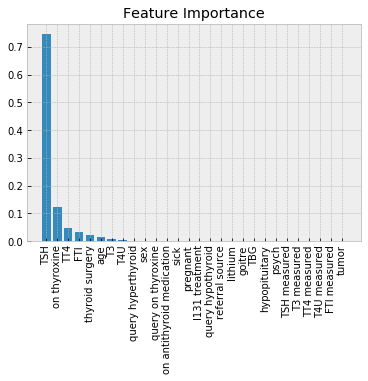

In [69]:
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

### Metrics for Test data

In [70]:
#Predict the response for test dataset
predicted_test = clf1.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, predicted_test))

Accuracy: 0.9946996466431095


In [71]:
#Predict the response for test dataset
measures_test      = classification_report(y_test, predicted_test) 
print("\nTesting data")
print(measures_test) 


Testing data
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        87
           1       1.00      1.00      1.00      1045

   micro avg       0.99      0.99      0.99      1132
   macro avg       0.98      0.98      0.98      1132
weighted avg       0.99      0.99      0.99      1132




Testing Data
[[  84    3]
 [   3 1042]]


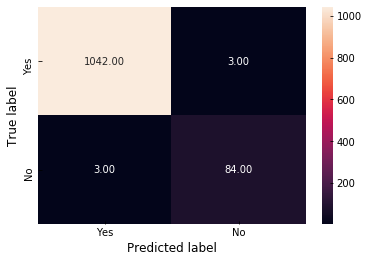

Testing Accuracy: 99.470%

Testing data
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        87
           1       1.00      1.00      1.00      1045

   micro avg       0.99      0.99      0.99      1132
   macro avg       0.98      0.98      0.98      1132
weighted avg       0.99      0.99      0.99      1132



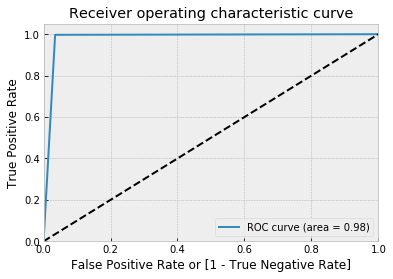

(array([0.        , 0.03448276, 1.        ]),
 array([0.        , 0.99712919, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [72]:
#Predict the response for test dataset
predicted_testing = clf1.predict(X_test)
matrix             = confusion_matrix(y_test, predicted_testing)
print("\nTesting Data")
print(matrix)
draw_cm(y_test, predicted_testing )
    
accuracy_train = clf1.score(X_test, y_test) 
print("Testing Accuracy: %.3f%%" % (accuracy_train * 100.0))
measures_test      = classification_report(y_test, predicted_testing) 
print("\nTesting data")
print(measures_test) 
draw_roc( y_test, predicted_testing) 


Threshold is 0.500 

[[1042    3]
 [   3   84]]


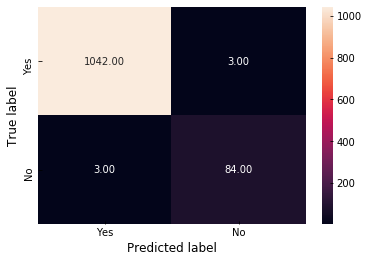

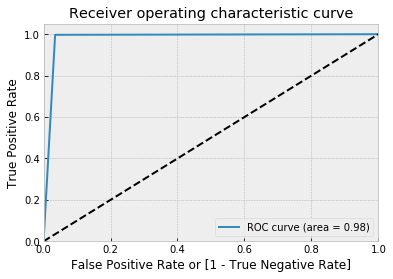

   Threshold    Recall  Precision  Accuracy Ratio
0        0.5  0.965517   0.965517       99.469965

Threshold is 0.520 

[[1042    3]
 [   3   84]]


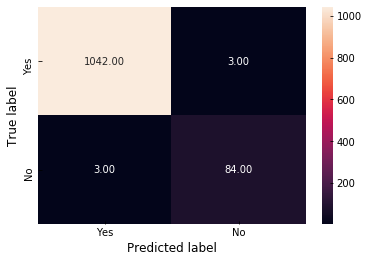

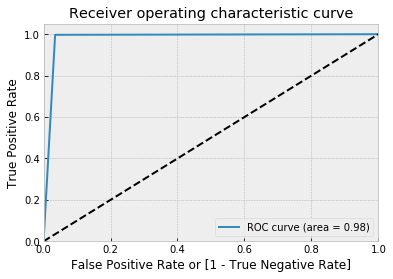

   Threshold    Recall  Precision  Accuracy Ratio
0       0.52  0.965517   0.965517       99.469965


In [73]:
predicted_proba_test              = clf1.predict_proba(X_test)
threshold__test_df                =  pd.DataFrame()  
threshold__test_df ['Actual']     =  y_test
threshold__test_df.dropna(inplace = True)
threshold_values                  = np.arange(0.50, 0.52, 0.02)
cutoff_df                         = pd.DataFrame()

for i in range(len(threshold_values)):
    
    threshold                         = threshold_values[i]
    print("\nThreshold is %0.3f" %threshold,"\n")
    threshold__test_df['Probability'] = predicted_proba_test[:,1]
    threshold__test_df['pred']        =  threshold__test_df['Probability'].map(lambda x: 1 \
                                                                  if x > threshold else 0)
    cm                                = confusion_matrix(threshold__test_df['Actual'].astype('int'),\
                                                   threshold__test_df['pred'],[1,0])
    print(cm)
    draw_cm(threshold__test_df['Actual'].astype('int'),\
                                                   threshold__test_df['pred'])
    draw_roc(threshold__test_df['Actual'].astype('int'),\
                                                   threshold__test_df['pred']) 
    precision                         = np.diag(cm) / np.sum(cm, axis = 0)
    recall                            = np.diag(cm) / np.sum(cm, axis = 1) 
    accuracy_ratio                    = ((cm[0,0] + cm[1,1]) * 100) / (cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    recall_positive                   = recall[1]
    precision_positive                = precision[1]
    cutoff_df_ind                     = pd.DataFrame({'Threshold': threshold, 'Recall' : recall_positive,\
                                               'Precision' : precision_positive,\
                                               'Accuracy Ratio' : accuracy_ratio},\
                                              index = [0])
    print(cutoff_df_ind)

    cutoff_df.append(cutoff_df_ind)  

In [75]:
feature_names = ['age', 'sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH',
       'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U',
       'FTI measured', 'FTI', 'TBG', 'referral source']

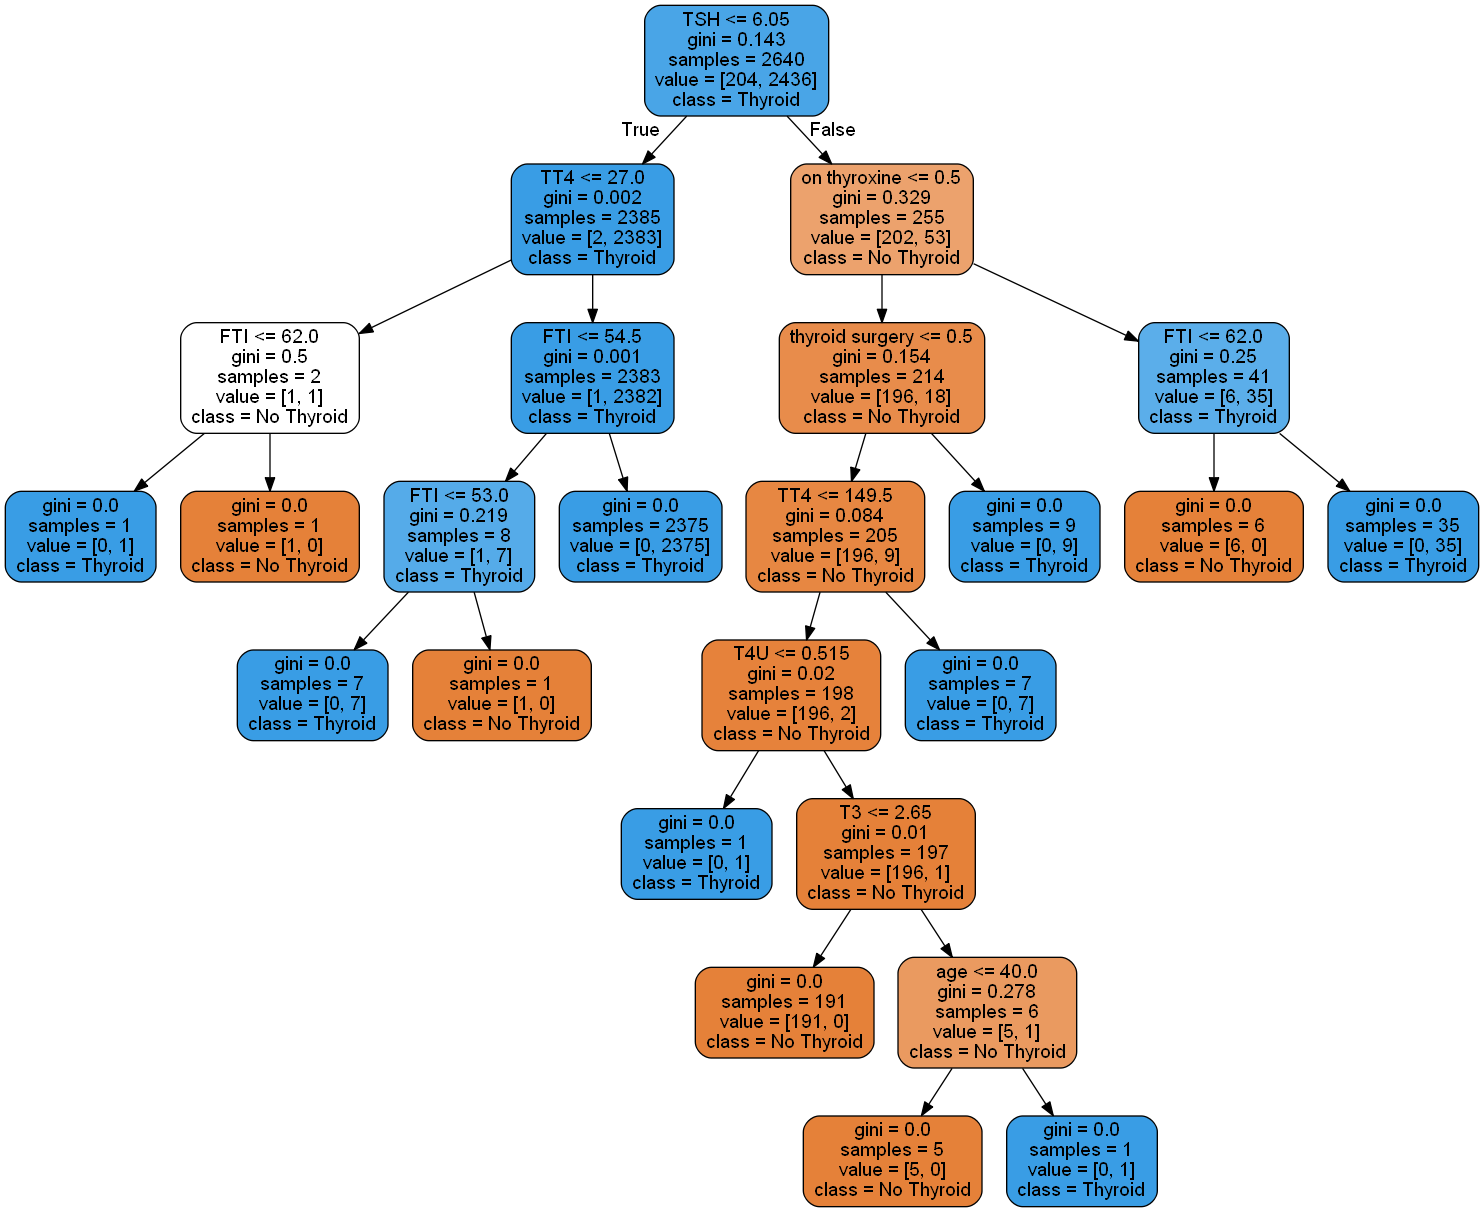

In [83]:
decision_tree_with_pruning(clf1, X_train, y_train, feature_names, 'binaryClass') #installed using conda install graphviz

In [85]:
tree_to_rules(clf1, list(X_train.loc[:,feature_names]), class_names)

 if ( TSH <= 6.049999952316284 ) {
   if ( TT4 <= 27.0 ) {
     if ( FTI <= 62.0 ) {
       Class = Thyroid
     } else {
       Class = No Thyroid
     }
   } else {
     if ( FTI <= 54.5 ) {
       if ( FTI <= 53.0 ) {
         Class = Thyroid
       } else {
         Class = No Thyroid
       }
     } else {
       Class = Thyroid
     }
   }
 } else {
   if ( on thyroxine <= 0.5 ) {
     if ( thyroid surgery <= 0.5 ) {
       if ( TT4 <= 149.5 ) {
         if ( T4U <= 0.5150000005960464 ) {
           Class = Thyroid
         } else {
           if ( T3 <= 2.649999976158142 ) {
             Class = No Thyroid
           } else {
             if ( age <= 40.0 ) {
               Class = No Thyroid
             } else {
               Class = Thyroid
             }
           }
         }
       } else {
         Class = Thyroid
       }
     } else {
       Class = Thyroid
     }
   } else {
     if ( FTI <= 62.0 ) {
       Class = No Thyroid
     } else {
       Class = Thyroid
    